overturning

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
db = '/scratch/e14/cy8964/access-om2/archive/databases/1deg_jra55_ryf_experiments_2.db'
session = cc.database.create_session(db)

In [3]:
exptdict = OrderedDict([
    ('Control',  {'expt':'1deg_jra55_ryf_RCPcont'}),
    ('Warming',  {'expt':'1deg_jra55_ryf_RCPwarmhumid'}),
    ('Warming x2',  {'expt':'1deg_jra55_ryf_RCPwarmhumid2x'}),
    ('Cooling',  {'expt':'1deg_jra55_ryf_RCPcoolhumid'}),
    ('Cooling x2',  {'expt':'1deg_jra55_ryf_RCPcoolhumid2x'}),
    ('Warming w/o humidity',  {'expt':'1deg_jra55_ryf_rcpwarm'}),
    ('Cooling w/o humidity',  {'expt':'1deg_jra55_ryf_rcpcool'}),
    ('Cooling w/o humidity2', {'expt':'1deg_jra55_ryf_RCPcool'}),
    ('Windup', {'expt':'1deg_jra55_ryf_red3DSK_C9'}),
    ('Cooling NA',  {'expt':'1deg_jra55_ryf_RCPcoolhumid_NA'}),
    ('Cooling SO',  {'expt':'1deg_jra55_ryf_RCPcoolhumid_SO'}),
    ('Warming NA',  {'expt':'1deg_jra55_ryf_RCPwarmhumid_NA'}),
    ('Warming SO',  {'expt':'1deg_jra55_ryf_RCPwarmhumid_SO'}),
    ('Warming PI',  {'expt':'1deg_jra55_ryf_RCPwarmhumid_PI'}),
    ('Cooling PI',  {'expt':'1deg_jra55_ryf_RCPcoolhumid_PI'}),
    ('Warming IP',  {'expt':'1deg_jra55_ryf_RCPwarmhumid_IP'}),
    ('Cooling IP',  {'expt':'1deg_jra55_ryf_RCPcoolhumid_IP'}),
    ('Warming SA',  {'expt':'1deg_jra55_ryf_RCPwarmhumid_SA'}),
    ('Cooling SA',  {'expt':'1deg_jra55_ryf_RCPcoolhumid_SA'})    
])


In [6]:
start_time = '2900-01-01'
end_time = '3000-01-01'

1deg_jra55_ryf_RCPwarmhumid
1deg_jra55_ryf_RCPwarmhumid2x
1deg_jra55_ryf_RCPcoolhumid
1deg_jra55_ryf_RCPcoolhumid2x
1deg_jra55_ryf_RCPcont
CPU times: user 2min 30s, sys: 10.1 s, total: 2min 40s
Wall time: 2min 26s


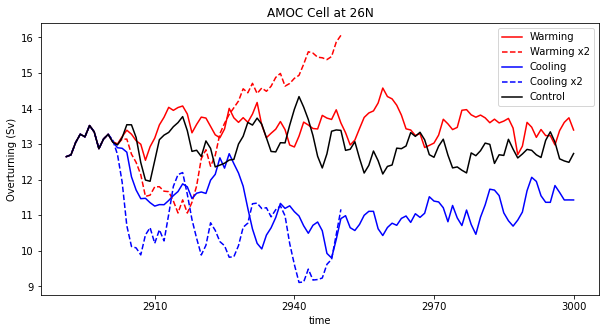

In [16]:
%%time
keys = ['Warming','Warming x2','Cooling','Cooling x2','Control']
colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--'}
start_time = '2900-01-01'
end_time = '3000-01-01'
plt.figure(figsize=(10,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session,start_time = start_time, end_time = end_time )
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session,start_time = start_time, end_time = end_time)
        psi_amoc_gm = var2.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho').resample(time='Y').mean()
    psi_amoc_sum.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
xlims = plt.xlim()
#plt.plot(xlims,[17.2,17.2],'--k',label='RAPID (McCarthy et al. 2015)')
plt.legend()
plt.title('AMOC Cell at 26N')
plt.ylabel('Overturning (Sv)')
plt.savefig('figures/AMOC100',dpi = 600)

1deg_jra55_ryf_RCPcont
1deg_jra55_ryf_RCPwarmhumid
1deg_jra55_ryf_RCPwarmhumid2x
1deg_jra55_ryf_RCPcoolhumid
1deg_jra55_ryf_RCPcoolhumid2x
1deg_jra55_ryf_RCPcoolhumid_NA
1deg_jra55_ryf_RCPcoolhumid_SO
1deg_jra55_ryf_RCPwarmhumid_NA
1deg_jra55_ryf_RCPwarmhumid_SO
1deg_jra55_ryf_RCPcoolhumid_PI
1deg_jra55_ryf_RCPwarmhumid_PI
1deg_jra55_ryf_RCPcoolhumid_IP
1deg_jra55_ryf_RCPwarmhumid_IP
1deg_jra55_ryf_RCPcoolhumid_SA
1deg_jra55_ryf_RCPwarmhumid_SA
CPU times: user 5min 16s, sys: 32.7 s, total: 5min 49s
Wall time: 7min 1s


Text(0, 0.5, 'Overturning (Sv)')

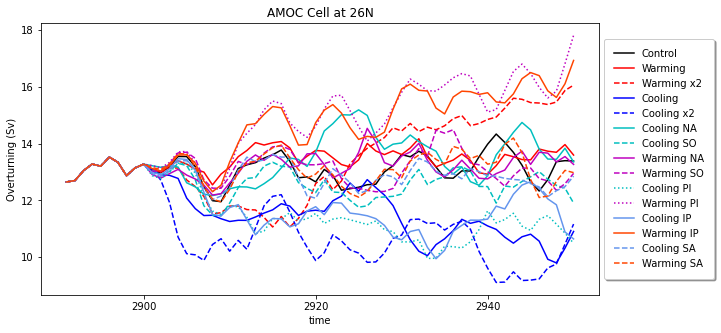

In [5]:
%%time
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2','Cooling NA', 'Cooling SO','Warming NA', 'Warming SO', 'Cooling PI', 'Warming PI', 'Cooling IP', 'Warming IP', 'Cooling SA', 'Warming SA']
colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Cooling NA':'c', 'Cooling SO':'c','Warming NA':'m','Warming SO':'m','Cooling PI':'c','Warming PI':'m',
         'Cooling IP':'cornflowerblue','Warming IP':'orangered','Cooling SA':'cornflowerblue','Warming SA':'orangered'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Cooling NA':'-', 'Cooling SO':'--','Warming NA':'-','Warming SO':'--','Warming PI':'dotted',
              'Cooling PI':'dotted','Cooling IP':'-','Warming IP':'-','Cooling SA':'--','Warming SA':'--' }
start_time = '2900-01-01'
plt.figure(figsize=(10,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session,start_time = start_time,end_time = end_time, ncfile = 'ocean.nc' )
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session,start_time = start_time,end_time = end_time, ncfile = 'ocean.nc')
        psi_amoc_gm = var2.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho').resample(time='Y').mean()
    psi_amoc_sum.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
xlims = plt.xlim()
#plt.plot(xlims,[17.2,17.2],'--k',label='RAPID (McCarthy et al. 2015)')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(1, 0.5),loc = 'center left')
plt.title('AMOC Cell at 26N')
plt.ylabel('Overturning (Sv)')

1deg_jra55_ryf_RCPcoolhumid_NA
1deg_jra55_ryf_RCPwarmhumid_NA
1deg_jra55_ryf_RCPcoolhumid_SO
1deg_jra55_ryf_RCPwarmhumid_SO
1deg_jra55_ryf_RCPcoolhumid_IP
1deg_jra55_ryf_RCPwarmhumid_IP
1deg_jra55_ryf_RCPcoolhumid_SA
1deg_jra55_ryf_RCPwarmhumid_SA
1deg_jra55_ryf_RCPcoolhumid
1deg_jra55_ryf_RCPwarmhumid
1deg_jra55_ryf_RCPcont
CPU times: user 3min 31s, sys: 14.1 s, total: 3min 45s
Wall time: 3min 19s


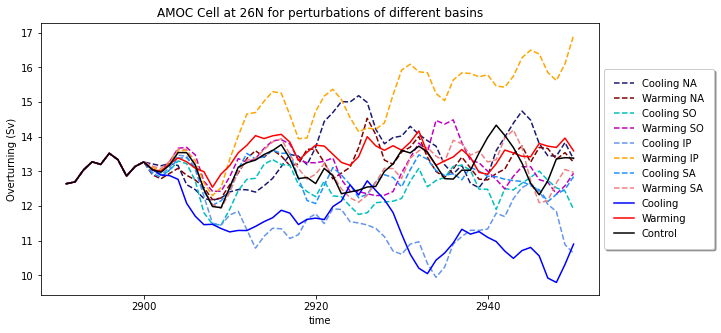

In [18]:
%%time
keys = ['Cooling NA', 'Warming NA', 'Cooling SO','Warming SO','Cooling IP', 'Warming IP', 'Cooling SA', 'Warming SA','Cooling','Warming','Control']
colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Cooling NA':'midnightblue', 'Cooling SO':'c','Warming NA':'maroon','Warming SO':'m','Cooling PI':'c','Warming PI':'m',
         'Cooling IP':'cornflowerblue','Warming IP':'orange','Cooling SA':'dodgerblue','Warming SA':'lightcoral'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Cooling NA':'--', 'Cooling SO':'--','Warming NA':'--','Warming SO':'--','Warming PI':'dotted',
              'Cooling PI':'dotted','Cooling IP':'--','Warming IP':'--','Cooling SA':'--','Warming SA':'--' }
start_time = '2900-01-01'
end_time = '2950-01-01'
plt.figure(figsize=(10,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session,start_time = start_time,end_time = end_time, ncfile = 'ocean.nc' )
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session,start_time = start_time,end_time = end_time, ncfile = 'ocean.nc')
        psi_amoc_gm = var2.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho').resample(time='Y').mean()
    psi_amoc_sum.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
xlims = plt.xlim()
#plt.plot(xlims,[17.2,17.2],'--k',label='RAPID (McCarthy et al. 2015)')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(1, 0.5),loc = 'center left')
plt.title('AMOC Cell at 26N for perturbations of different basins')
plt.ylabel('Overturning (Sv)')
plt.savefig('figures/AMOCbasin',dpi = 600)

1deg_jra55_ryf_RCPcont
1deg_jra55_ryf_RCPwarmhumid
1deg_jra55_ryf_RCPcoolhumid
1deg_jra55_ryf_RCPcoolhumid_NA
1deg_jra55_ryf_RCPcoolhumid_SO
1deg_jra55_ryf_RCPwarmhumid_NA
1deg_jra55_ryf_RCPwarmhumid_SO
CPU times: user 2min 15s, sys: 15.6 s, total: 2min 31s
Wall time: 2min 24s


Text(0, 0.5, 'Overturning (Sv)')

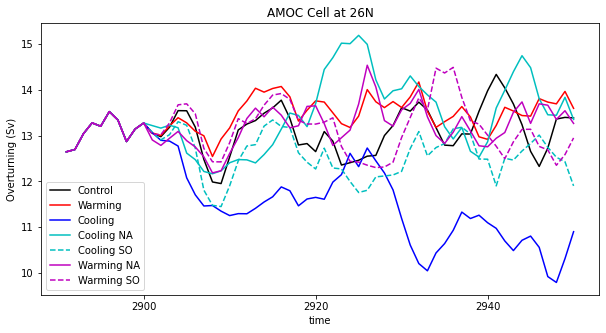

In [21]:
%%time
keys = ['Control','Warming','Cooling','Cooling NA', 'Cooling SO','Warming NA', 'Warming SO']
colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Cooling NA':'c', 'Cooling SO':'c','Warming NA':'m','Warming SO':'m'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Cooling NA':'-', 'Cooling SO':'--','Warming NA':'-','Warming SO':'--'}
start_time = '2900-01-01'
plt.figure(figsize=(10,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session,start_time = start_time, ncfile = 'ocean.nc' )
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session,start_time = start_time, ncfile = 'ocean.nc')
        psi_amoc_gm = var2.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho').resample(time='Y').mean()
    psi_amoc_sum.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
xlims = plt.xlim()
#plt.plot(xlims,[17.2,17.2],'--k',label='RAPID (McCarthy et al. 2015)')
plt.legend()
plt.title('AMOC Cell at 26N')
plt.ylabel('Overturning (Sv)')

In [22]:
1+2

3

suggests that the AMOC volume transport is actually INCREASING in the warming case. Consistent with other model output but opposite to what we might initially think.

1deg_jra55_ryf_RCPcont
1deg_jra55_ryf_RCPwarmhumid
1deg_jra55_ryf_RCPwarmhumid2x
1deg_jra55_ryf_RCPcoolhumid
1deg_jra55_ryf_RCPcoolhumid2x
CPU times: user 1min 12s, sys: 7.57 s, total: 1min 19s
Wall time: 1min


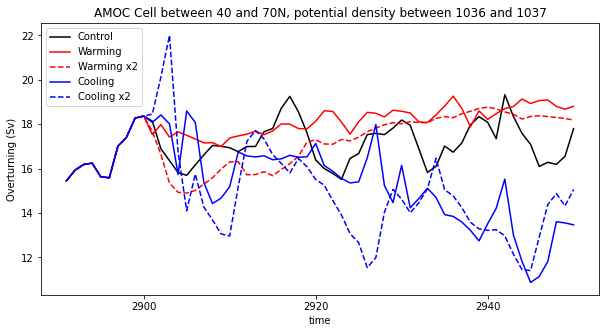

In [6]:
%%time
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2']
colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--'}
start_time = '2900-01-01'
plt.figure(figsize=(10,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session,start_time = start_time )
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean')*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session,start_time = start_time)
        psi_amoc_gm = var2.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean')*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum_Sv = psi_amoc_sum.sel(grid_yu_ocean = slice(40,70)).sel(potrho=slice(1036,1037)).max('potrho').max('grid_yu_ocean').resample(time='Y').mean()
    psi_amoc_sum_Sv.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
#     psi_amoc_sum_y = psi_amoc_sum.sel(grid_yu_ocean = slice(40,70)).sel(potrho=slice(1036,1037)).idxmax('grid_yu_ocean').resample(time='Y').mean()
#     psi_amoc_sum_y.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
#     psi_amoc_sum_rho = psi_amoc_sum.sel(grid_yu_ocean = slice(40,70)).sel(potrho=slice(1036,1037)).idxmax('potrho').resample(time='Y').mean()
#     psi_amoc_sum_rho.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
    
xlims = plt.xlim()
#plt.plot(xlims,[17.2,17.2],'--k',label='RAPID (McCarthy et al. 2015)')
plt.legend()
plt.title('AMOC Cell between 40 and 70N, potential density between 1036 and 1037')
plt.ylabel('Overturning (Sv)')
plt.savefig('figures/amoc')

1deg_jra55_ryf_RCPcont
1deg_jra55_ryf_RCPwarmhumid
1deg_jra55_ryf_RCPwarmhumid2x
1deg_jra55_ryf_RCPcoolhumid
1deg_jra55_ryf_RCPcoolhumid2x
CPU times: user 1min 13s, sys: 6.18 s, total: 1min 19s
Wall time: 54.9 s


Text(0, 0.5, 'Latitude where AMOC is maximum')

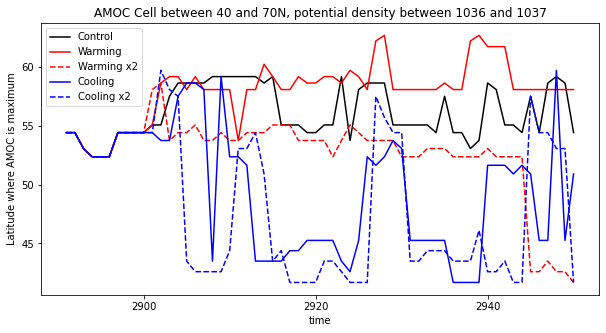

In [16]:
%%time
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2']
colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--'}
start_time = '2900-01-01'
plt.figure(figsize=(10,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session,start_time = start_time )
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean')*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session,start_time = start_time)
        psi_amoc_gm = var2.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean')*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
#     psi_amoc_sum_Sv = psi_amoc_sum.sel(grid_yu_ocean = slice(40,70)).sel(potrho=slice(1036,1037)).max('potrho').max('grid_yu_ocean').resample(time='Y').mean()
#     psi_amoc_sum_Sv.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
    psi_amoc_sum_y = psi_amoc_sum.sel(grid_yu_ocean = slice(40,70)).sel(potrho=slice(1036,1037)).max('potrho').idxmax('grid_yu_ocean').resample(time='Y').mean()
    psi_amoc_sum_y.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
#     psi_amoc_sum_rho = psi_amoc_sum.sel(grid_yu_ocean = slice(40,70)).sel(potrho=slice(1036,1037)).idxmax('potrho').resample(time='Y').mean()
#     psi_amoc_sum_rho.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
    
xlims = plt.xlim()
#plt.plot(xlims,[17.2,17.2],'--k',label='RAPID (McCarthy et al. 2015)')
plt.legend()
plt.title('AMOC Cell between 40 and 70N, potential density between 1036 and 1037')
plt.ylabel('Latitude where AMOC is maximum')

1deg_jra55_ryf_RCPcont
1deg_jra55_ryf_RCPwarmhumid
1deg_jra55_ryf_RCPwarmhumid2x
1deg_jra55_ryf_RCPcoolhumid
1deg_jra55_ryf_RCPcoolhumid2x
CPU times: user 1min 12s, sys: 6.17 s, total: 1min 18s
Wall time: 53.9 s


Text(0, 0.5, 'Potential density where AMOC is maximum')

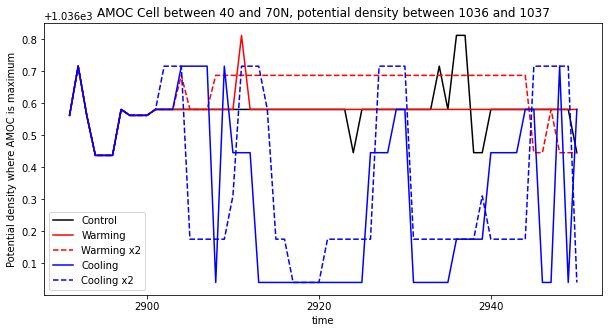

In [17]:
%%time
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2']
colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--'}
start_time = '2900-01-01'
plt.figure(figsize=(10,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session,start_time = start_time )
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean')*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session,start_time = start_time)
        psi_amoc_gm = var2.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean')*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
#     psi_amoc_sum_Sv = psi_amoc_sum.sel(grid_yu_ocean = slice(40,70)).sel(potrho=slice(1036,1037)).max('potrho').max('grid_yu_ocean').resample(time='Y').mean()
#     psi_amoc_sum_Sv.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
#     psi_amoc_sum_y = psi_amoc_sum.sel(grid_yu_ocean = slice(40,70)).sel(potrho=slice(1036,1037)).idxmax('grid_yu_ocean').resample(time='Y').mean()
#     psi_amoc_sum_y.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
    psi_amoc_sum_rho = psi_amoc_sum.sel(grid_yu_ocean = slice(40,70)).sel(potrho=slice(1036,1037)).max('grid_yu_ocean').idxmax('potrho').resample(time='Y').mean()
    psi_amoc_sum_rho.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
    
xlims = plt.xlim()
#plt.plot(xlims,[17.2,17.2],'--k',label='RAPID (McCarthy et al. 2015)')
plt.legend()
plt.title('AMOC Cell between 40 and 70N, potential density between 1036 and 1037')
plt.ylabel('Potential density where AMOC is maximum')

In [9]:
psi_amoc_sum

<xarray.DataArray (time: 60, grid_yu_ocean: 48)>
dask.array<stack, shape=(60, 48), dtype=float32, chunksize=(1, 48), chunktype=numpy.ndarray>
Coordinates:
  * time           (time) object 2890-12-31 00:00:00 ... 2949-12-31 00:00:00
  * grid_yu_ocean  (grid_yu_ocean) float64 40.75 41.68 42.59 ... 69.12 69.58

## missing temp_yflux_submeso_int_z

In [15]:
def find_MHF_intz(ekey):
    expt = exptdict[ekey]['expt']
    #n_files = exptdict[ekey]['n_files']
    # n_files = 1
    #time_units = exptdict[ekey]['time_units']
    #offset = exptdict[ekey]['offset']

    temp_yflux_adv = cc.querying.getvar(expt, 'temp_yflux_adv_int_z', session)
    #temp_yflux_submeso = cc.querying.getvar(expt, 'temp_yflux_submeso_int_z', session)
    MHF = (temp_yflux_adv.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')).load()#+temp_yflux_submeso.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')).load()
    if (ekey != '01deg'):
        temp_yflux_gm = cc.querying.getvar(expt,'temp_yflux_gm_int_z', session)
        temp_yflux_ndiffuse = cc.querying.getvar(expt, 'temp_yflux_ndiffuse_int_z',session)
        MHF = MHF + (temp_yflux_gm.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')+temp_yflux_ndiffuse.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')).load()

    latv = cc.querying.getvar(expt, 'yu_ocean',session, n=1).load()
    return latv, MHF

Control


Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/sqlalchemy/engine/default.py", line 543, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 23139596678976 and this is thread id 23138641692416.
Exception closing connection <sqlite3.Connection object at 0x150b62b4b8f0>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/sqlalchemy/po

Warming
Warming x2
Cooling
Cooling x2
Warming w/o humidity


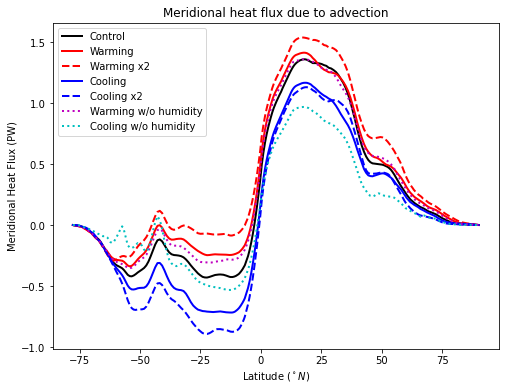

In [19]:
fig = plt.figure(figsize=(8,6))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')
tstart = '2949-01-01'
tend = '2950-01-01'
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2', 'Warming w/o humidity']

colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Warming w/o humidity':'m','Cooling w/o humidity2':'c'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Warming w/o humidity':'dotted','Cooling w/o humidity2':'dotted'}

for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz(ekey)
    hand = plt.plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])

#now the two cooling experiments bc they are split up
expt1 = '1deg_jra55_ryf_rcpcool'
temp_yflux_adv1 = cc.querying.getvar(expt1, 'temp_yflux_adv_int_z', session).sel(time = slice('2900-01-01','2909-01-01'))
expt2 = '1deg_jra55_ryf_RCPcool'
temp_yflux_adv2 = cc.querying.getvar(expt2, 'temp_yflux_adv_int_z', session).sel(time = slice('2909-01-01','2949-01-01'))
temp_yflux_adv_combined = xr.concat([temp_yflux_adv1,temp_yflux_adv2], dim = 'time')
MHF = (temp_yflux_adv_combined.mean('time').sum('xt_ocean')).load()#+temp_yflux_submeso.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')).load()
latv = cc.querying.getvar(expt2, 'yu_ocean',session, n=1).load()
hand = plt.plot(latv,MHF/1.e15,linewidth=2, label='Cooling w/o humidity', color = 'c', linestyle = 'dotted')

plt.legend()
plt.title('Meridional heat flux due to advection')
plt.savefig('figures/meridional_heat_flux')

# Quantifying anomalies

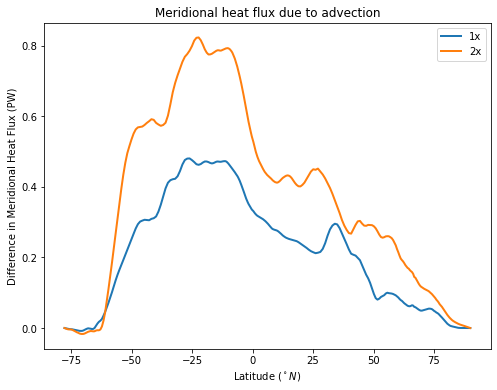

In [7]:
fig = plt.figure(figsize=(8,6))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Difference in Meridional Heat Flux (PW)')
tstart = '2949-01-01'
tend = '2950-01-01'
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2', 'Warming w/o humidity']

colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Warming w/o humidity':'m','Cooling w/o humidity2':'c'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Warming w/o humidity':'dotted','Cooling w/o humidity2':'dotted'}

ekey = keys[0]
latv, MHFc = find_MHF_intz(ekey)
ekey = keys[1]
latvw, MHFw = find_MHF_intz(ekey)
ekey = keys[3]
latvc, MHFc = find_MHF_intz(ekey)
hand = plt.plot(latv,(MHFw-MHFc)/1.e15,linewidth=2, label='1x')
ekey = keys[0]
latv, MHFc = find_MHF_intz(ekey)
ekey = keys[2]
latvw, MHFw = find_MHF_intz(ekey)
ekey = keys[4]
latvc, MHFc = find_MHF_intz(ekey)
hand = plt.plot(latv,(MHFw-MHFc)/1.e15,linewidth=2, label='2x')


plt.legend()
plt.title('Meridional heat flux due to advection')
plt.savefig('figures/meridional_heat_flux')

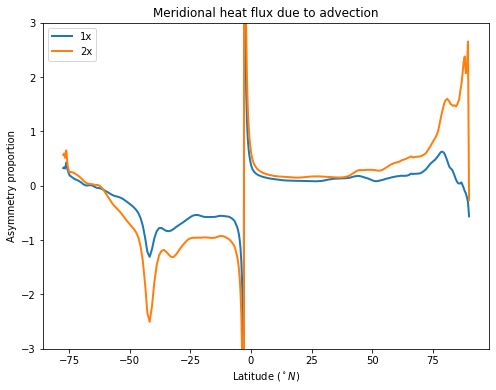

In [10]:
fig = plt.figure(figsize=(8,6))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Asymmetry proportion')
tstart = '2949-01-01'
tend = '2950-01-01'
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2', 'Warming w/o humidity']

colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Warming w/o humidity':'m','Cooling w/o humidity2':'c'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Warming w/o humidity':'dotted','Cooling w/o humidity2':'dotted'}

ekey = keys[0]
latv, MHFc = find_MHF_intz(ekey)
ekey = keys[1]
latvw, MHFw = find_MHF_intz(ekey)
ekey = keys[3]
latvco, MHFco = find_MHF_intz(ekey)
hand = plt.plot(latv,(MHFw-MHFco)/2/MHFc,linewidth=2, label='1x')
ekey = keys[0]
latv, MHFc = find_MHF_intz(ekey)
ekey = keys[2]
latvw, MHFw = find_MHF_intz(ekey)
ekey = keys[4]
latvco, MHFco = find_MHF_intz(ekey)
hand = plt.plot(latv,(MHFw-MHFco)/2/MHFc,linewidth=2, label='2x')

plt.ylim(-3,3)
plt.legend()
plt.title('Meridional heat flux due to advection')
plt.savefig('figures/meridional_heat_flux')

Control
Warming
Warming x2
Cooling
Cooling x2
Warming w/o humidity


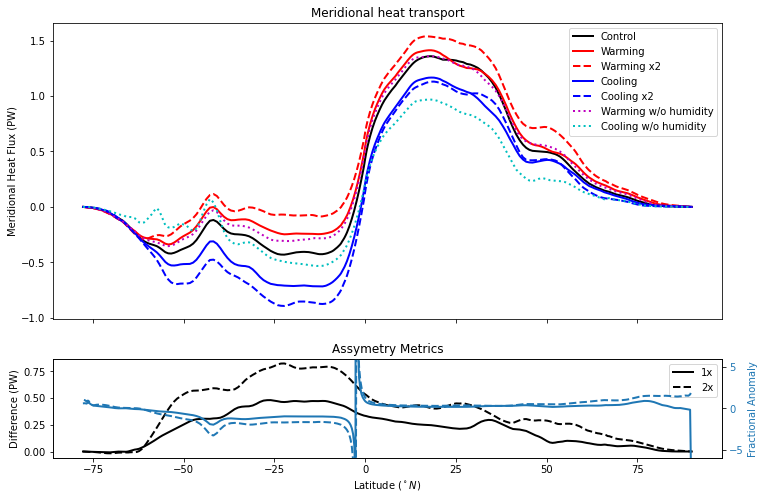

In [17]:
fig, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex = True, figsize = (12,8))
tstart = '2949-01-01'
tend = '2950-01-01'
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2', 'Warming w/o humidity']

colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Warming w/o humidity':'m','Cooling w/o humidity2':'c'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Warming w/o humidity':'dotted','Cooling w/o humidity2':'dotted'}

for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz(ekey)
    hand = axes[0].plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])

#now the two cooling experiments bc they are split up
expt1 = '1deg_jra55_ryf_rcpcool'
temp_yflux_adv1 = cc.querying.getvar(expt1, 'temp_yflux_adv_int_z', session).sel(time = slice('2900-01-01','2909-01-01'))
expt2 = '1deg_jra55_ryf_RCPcool'
temp_yflux_adv2 = cc.querying.getvar(expt2, 'temp_yflux_adv_int_z', session).sel(time = slice('2909-01-01','2949-01-01'))
temp_yflux_adv_combined = xr.concat([temp_yflux_adv1,temp_yflux_adv2], dim = 'time')
MHF = (temp_yflux_adv_combined.mean('time').sum('xt_ocean')).load()#+temp_yflux_submeso.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')).load()
latv = cc.querying.getvar(expt2, 'yu_ocean',session, n=1).load()
hand = axes[0].plot(latv,MHF/1.e15,linewidth=2, label='Cooling w/o humidity', color = 'c', linestyle = 'dotted')
axes[0].set_ylabel('Meridional Heat Flux (PW)')
axes[0].legend()
axes[0].set_title('Meridional heat transport')

ax2 = axes[1].twinx() 

ekey = keys[0]
latv, MHFc = find_MHF_intz(ekey)
ekey = keys[1]
latvw, MHFw = find_MHF_intz(ekey)
ekey = keys[3]
latvc, MHFc = find_MHF_intz(ekey)
hand = axes[1].plot(latv,(MHFw-MHFc)/1.e15,linewidth=2, label='1x', color = 'k')
hand = ax2.plot(latv,(MHFw-MHFc)*2/(MHFw+MHFc),linewidth=2, color = 'tab:blue')

ekey = keys[0]
latv, MHFc = find_MHF_intz(ekey)
ekey = keys[2]
latvw, MHFw = find_MHF_intz(ekey)
ekey = keys[4]
latvc, MHFc = find_MHF_intz(ekey)
hand = axes[1].plot(latv,(MHFw-MHFc)/1.e15,linewidth=2, label='2x',color = 'k', linestyle = '--')
hand = ax2.plot(latv,(MHFw-MHFc)*2/(MHFw+MHFc),linewidth=2, color = 'tab:blue',linestyle = '--')

axes[1].set_ylabel('Difference (PW)')
axes[1].legend()
axes[1].set_title('Assymetry Metrics')
axes[1].set_xlabel('Latitude $(^\circ N)$')

color = 'tab:blue'
ax2.set_ylabel('Fractional Anomaly', color=color)# we already handled the x-label with ax1
ax2.set_ylim(-6,6)
ax2.tick_params(axis='y', labelcolor=color)
plt.savefig('figures/MHT',dpi = 600)

In [48]:
temp_yflux_adv_combined

,Array,Chunk
Bytes,254.02 MB,432.00 kB
Shape,"(588, 300, 360)","(1, 300, 360)"
Count,3104 Tasks,588 Chunks
Type,float32,numpy.ndarray


Control
Warming
Warming x2
Cooling
Cooling x2
Warming w/o humidity
Cooling w/o humidity


Text(0.5, 1.0, 'Meridional heat flux due to advection years 1-10')

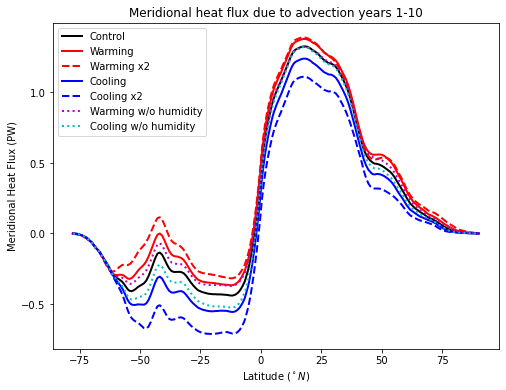

In [41]:
fig = plt.figure(figsize=(8,6))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')
tstart = '2900-01-01'
tend = '2910-01-01'
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2', 'Warming w/o humidity', 'Cooling w/o humidity']

colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Warming w/o humidity':'m','Cooling w/o humidity':'c'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Warming w/o humidity':'dotted','Cooling w/o humidity':'dotted'}

for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz(ekey)
    hand = plt.plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])
    
plt.legend()
plt.title('Meridional heat flux due to advection years 1-10')

Control
Warming
Warming x2
Cooling
Cooling x2
Warming w/o humidity
Cooling w/o humidity2


Text(0.5, 1.0, 'Meridional heat flux due to advection years 40-50')

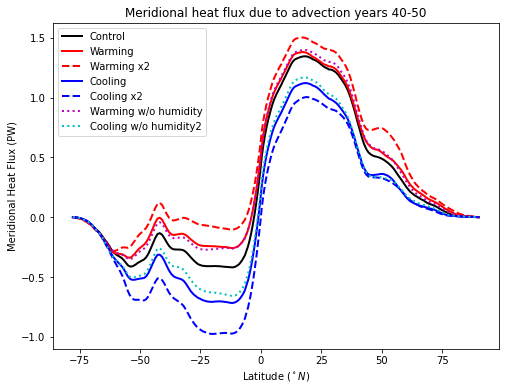

In [42]:
fig = plt.figure(figsize=(8,6))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')
tstart = '2940-01-01'
tend = '2950-01-01'
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2', 'Warming w/o humidity', 'Cooling w/o humidity2']

colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Warming w/o humidity':'m','Cooling w/o humidity2':'c'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Warming w/o humidity':'dotted','Cooling w/o humidity2':'dotted'}

for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz(ekey)
    hand = plt.plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])
    
plt.legend()
plt.title('Meridional heat flux due to advection years 40-50')

this means that in the warming case, the meridional heat flux increases so there is more heat pumping northwards and less southwards from the equator.

so the prediction that pumping slows, causing a cooling in northern hemisphere, might not be right (to explain the increase in surface flux at 40N in the 2x warming)

similarly, when the atmosphere is cooled, there is more heat pumping southwards and less northwards.

if the humidity is not changed then there is less of an anomaly from the control. this is because (in warming case) heat can be lost from equator, so less heat to advect northwards compared to if heat can't just evaporate at equator.

making masks for atlantic and indo-pacific

In [6]:
expt = '1deg_jra55_ryf_RCPcont'
ht = cc.querying.getvar(expt,'ht',session,n=-1)
land_mask = ~ht.isnull()

south_map = (land_mask.where(land_mask.yt_ocean < -34)).fillna(0) 
indo_map1 = (land_mask.where(land_mask.yt_ocean < 9).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-65)).fillna(0) 
indo_map2 = (land_mask.where(land_mask.yt_ocean < 15).where(land_mask.yt_ocean > 9).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-83.7)).fillna(0) 
indo_map3 = (land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-93.3)).fillna(0) 
indo_map4 = (land_mask.where(land_mask.yt_ocean < 85).where(land_mask.yt_ocean > 17).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-99)).fillna(0) 
indo_map5 = (land_mask.where(land_mask.yt_ocean < 30.5).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >25).where(land_mask.xt_ocean<80)).fillna(0) 
indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
atlantic_sector_map = atlantic_sector_map + south_map
atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map>0)

Text(0.5, 1.0, 'Indo-Pacific + Southern Ocean Mask')

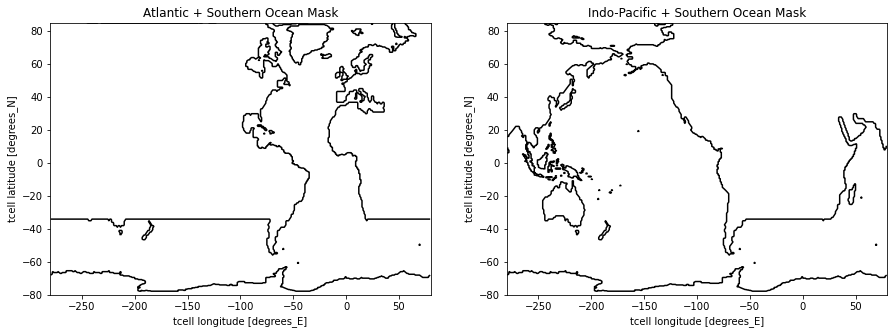

In [7]:
fig, ax=plt.subplots(1,2, figsize=(15,5))

atlantic_sector_map.plot.contour(ax=ax[0],levels=[0.5],colors='k')
ax[0].set_xlim([-280,80])
ax[0].set_ylim([-80,85])
ax[0].set_title('Atlantic + Southern Ocean Mask')
indo_sector_map.plot.contour(ax=ax[1],levels=[0.5],colors='k')
ax[1].set_xlim([-280,80])
ax[1].set_ylim([-80,85])
ax[1].set_title('Indo-Pacific + Southern Ocean Mask')



In [8]:
atlantic_sector_mask

<xarray.DataArray 'ht' (yt_ocean: 300, xt_ocean: 360)>
dask.array<where, shape=(300, 360), dtype=float64, chunksize=(300, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>

In [9]:
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2', 'Warming w/o humidity', 'Cooling w/o humidity2']

colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Warming w/o humidity':'m','Cooling w/o humidity2':'c'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Warming w/o humidity':'dotted','Cooling w/o humidity2':'dotted'}


In [10]:
temp_yflux_adv = cc.querying.getvar(expt, 'temp_yflux_adv_int_z', session)
#atlantic_sector_mask*temp_yflux_adv

In [ ]:
#(atlantic_sector_mask*temp_yflux_adv).isel(time =0).isel(xt_ocean=0).isel(yu_ocean=0).plot()

In [11]:
psi = cc.querying.getvar(expt,'temp_yflux_adv_int_z',session, n=1) ## needs to be the same coordinates as what you want to mask
#atlantic_sector_mask.coords['xt_ocean'] = psi.xt_ocean.values
atlantic_sector_mask.coords['yt_ocean'] = psi.yu_ocean.values
atlantic_sector_mask = atlantic_sector_mask.rename({'xt_ocean':'xt_ocean','yt_ocean':'yu_ocean'})
#indo_sector_mask.coords['xt_ocean'] = psi.xt_ocean.values
indo_sector_mask.coords['yt_ocean'] = psi.yu_ocean.values
indo_sector_mask = indo_sector_mask.rename({'xt_ocean':'xt_ocean','yt_ocean':'yu_ocean'})



In [12]:
def find_MHF_intz_basin(ekey, basin_mask):
    expt = exptdict[ekey]['expt']
    #n_files = exptdict[ekey]['n_files']
    # n_files = 1
    #time_units = exptdict[ekey]['time_units']
    #offset = exptdict[ekey]['offset']

    temp_yflux_adv = cc.querying.getvar(expt, 'temp_yflux_adv_int_z', session)
    temp_yflux_adv = temp_yflux_adv*basin_mask
    #temp_yflux_submeso = cc.querying.getvar(expt, 'temp_yflux_submeso_int_z', session)
    MHF = (temp_yflux_adv.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')).load()#+temp_yflux_submeso.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')).load()
    if (ekey != '01deg'):
        temp_yflux_gm = cc.querying.getvar(expt,'temp_yflux_gm_int_z', session)
        temp_yflux_ndiffuse = cc.querying.getvar(expt, 'temp_yflux_ndiffuse_int_z',session)
        MHF = MHF + (temp_yflux_gm.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')+temp_yflux_ndiffuse.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')).load()
        
    latv = cc.querying.getvar(expt, 'yu_ocean',session, n=1).load()
    return latv, MHF

In [13]:
tstart = '2940-01-01'
tend = '2950-01-01'

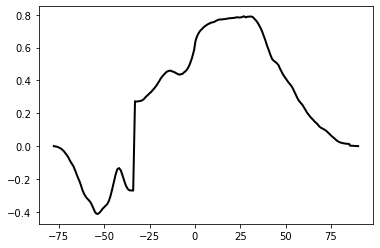

In [14]:
ekey = 'Control'
latv, MHF = find_MHF_intz_basin(ekey, atlantic_sector_mask)
hand = plt.plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])

Control
Warming
Warming x2
Cooling
Cooling x2
Warming w/o humidity
Cooling w/o humidity


Text(0.5, 1.0, 'Meridional heat flux due to advection years 1-10 - Atlantic')

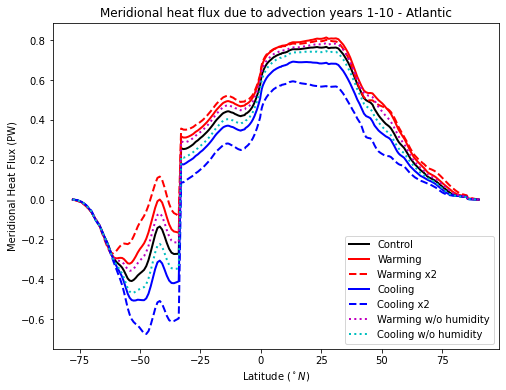

In [16]:
fig = plt.figure(figsize=(8,6))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')
tstart = '2948-01-01'
tend = '2949-01-01'
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2', 'Warming w/o humidity', 'Cooling w/o humidity']

colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Warming w/o humidity':'m','Cooling w/o humidity':'c'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Warming w/o humidity':'dotted','Cooling w/o humidity':'dotted'}

for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz_basin(ekey, atlantic_sector_mask)
    hand = plt.plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])
    
plt.legend()
plt.title('Atlantic')

Control
Warming
Warming x2
Cooling
Cooling x2
Control
Warming
Warming x2
Cooling
Cooling x2


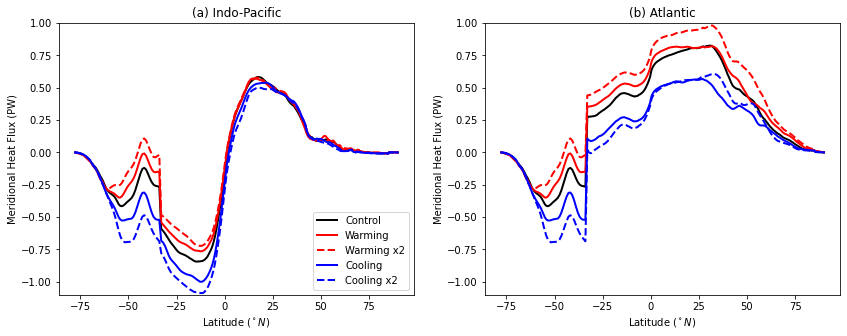

In [17]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (14,5))
tstart = '2948-01-01'
tend = '2949-01-01'
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2']#, 'Warming w/o humidity', 'Cooling w/o humidity']

colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Warming w/o humidity':'m','Cooling w/o humidity':'c'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Warming w/o humidity':'dotted','Cooling w/o humidity':'dotted'}

for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz_basin(ekey, indo_sector_mask)
    hand = axes[0].plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])
axes[0].set_title('(a) Indo-Pacific')
axes[0].set_ylim(-1.1,1)
axes[0].set_xlabel('Latitude $(^\circ N)$')
axes[0].set_ylabel('Meridional Heat Flux (PW)')

for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz_basin(ekey, atlantic_sector_mask)
    hand = axes[1].plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])
axes[1].set_title('(b) Atlantic')
axes[1].set_ylim(-1.1,1)
axes[1].set_xlabel('Latitude $(^\circ N)$')
axes[1].set_ylabel('Meridional Heat Flux (PW)')
axes[0].legend(loc = 'lower right')

Control
Warming
Warming x2
Cooling
Cooling x2
Warming w/o humidity
Cooling w/o humidity
Control
Warming
Warming x2
Cooling
Cooling x2
Warming w/o humidity
Cooling w/o humidity
Control
Warming
Warming x2
Cooling
Cooling x2
Warming w/o humidity
Cooling w/o humidity
Control
Warming
Warming x2
Cooling
Cooling x2
Warming w/o humidity
Cooling w/o humidity2
Control
Warming
Warming x2
Cooling
Cooling x2
Warming w/o humidity
Cooling w/o humidity2
Control
Warming
Warming x2
Cooling
Cooling x2
Warming w/o humidity
Cooling w/o humidity2


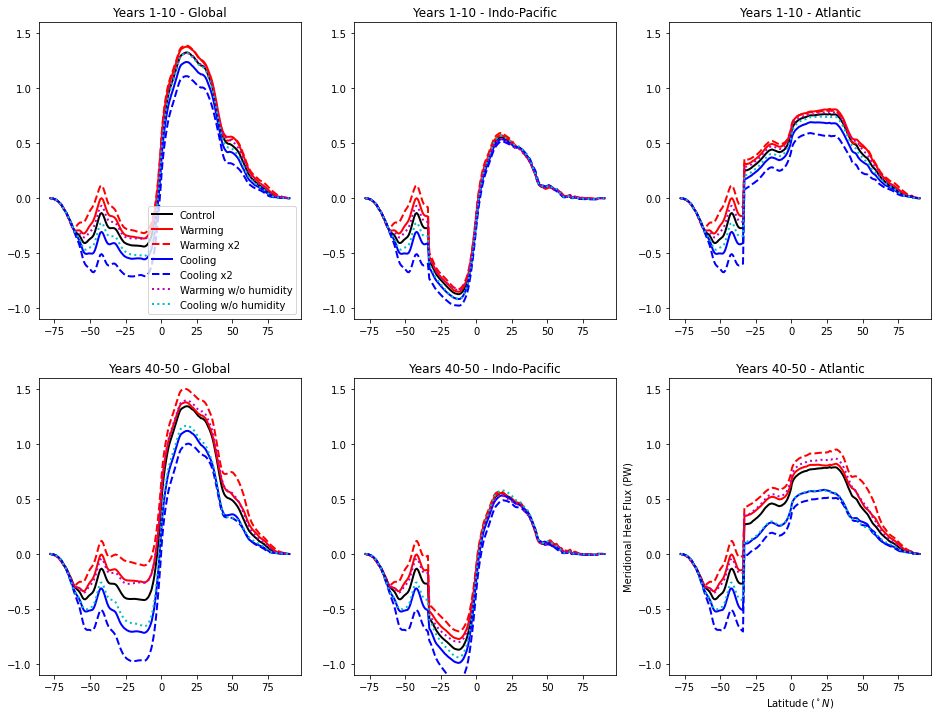

In [17]:
#fig = plt.figure(figsize=(8,6),
fig, axes = plt.subplots(ncols=3, nrows=2, figsize = (16,12))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')

keys = ['Control','Warming','Warming x2','Cooling','Cooling x2', 'Warming w/o humidity', 'Cooling w/o humidity']
colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Warming w/o humidity':'m','Cooling w/o humidity':'c'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Warming w/o humidity':'dotted','Cooling w/o humidity':'dotted'}
tstart = '2900-01-01'
tend = '2910-01-01'

for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz(ekey)
    hand = axes[0,0].plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])
    
axes[0,0].legend()
axes[0,0].set_title('Years 1-10 - Global')
axes[0,0].set_ylim(-1.1,1.6)
for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz_basin(ekey, indo_sector_mask)
    hand = axes[0,1].plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])
axes[0,1].set_title('Years 1-10 - Indo-Pacific')
axes[0,1].set_ylim(-1.1,1.6)
for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz_basin(ekey, atlantic_sector_mask)
    hand = axes[0,2].plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])
axes[0,2].set_title('Years 1-10 - Atlantic')
axes[0,2].set_ylim(-1.1,1.6)
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2', 'Warming w/o humidity', 'Cooling w/o humidity2']
colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Warming w/o humidity':'m','Cooling w/o humidity2':'c'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Warming w/o humidity':'dotted','Cooling w/o humidity2':'dotted'}
tstart = '2940-01-01'
tend = '2950-01-01'

for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz(ekey)
    hand = axes[1,0].plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])
    
axes[1,0].set_title('Years 40-50 - Global')
axes[1,0].set_ylim(-1.1,1.6)
for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz_basin(ekey, indo_sector_mask)
    hand = axes[1,1].plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])
axes[1,1].set_title('Years 40-50 - Indo-Pacific')
axes[1,1].set_ylim(-1.1,1.6)
for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz_basin(ekey, atlantic_sector_mask)
    hand = axes[1,2].plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])
axes[1,2].set_title('Years 40-50 - Atlantic')
axes[1,2].set_ylim(-1.1,1.6)
plt.savefig('figures/meridional_heat_flux_basin')

southern overturning circulation

use indo mask (DIFFERENT TO ABOVE)

In [18]:
south_map = (land_mask.where(land_mask.yt_ocean < -34)).fillna(0) 
indo_map1 = (land_mask.where(land_mask.yt_ocean < 9).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-65)).fillna(0) 
indo_map2 = (land_mask.where(land_mask.yt_ocean < 15).where(land_mask.yt_ocean > 9).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-83.7)).fillna(0) 
indo_map3 = (land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-93.3)).fillna(0) 
indo_map4 = (land_mask.where(land_mask.yt_ocean < 85).where(land_mask.yt_ocean > 17).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-99)).fillna(0) 
indo_map5 = (land_mask.where(land_mask.yt_ocean < 30.5).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >25).where(land_mask.xt_ocean<80)).fillna(0) 
indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
atlantic_sector_map = atlantic_sector_map + south_map
atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map>0)

psi = cc.querying.getvar(expt,'ty_trans_rho',session, n=1) ## needs to be the same coordinates as what you want to mask
atlantic_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
atlantic_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
atlantic_sector_mask = atlantic_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})
indo_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
indo_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
indo_sector_mask = indo_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})



In [19]:
start_time = '2900-01-31'
gm = cc.querying.getvar(expt,'ty_trans_rho_gm',session,start_time = start_time )
notgm = cc.querying.getvar(expt,'ty_trans_rho',session,start_time = start_time )
notgm

,Array,Chunk
Bytes,1.60 GB,4.00 MB
Shape,"(50, 74, 300, 360)","(1, 37, 150, 180)"
Count,805 Tasks,400 Chunks
Type,float32,numpy.ndarray


In [20]:
psi_amoc_gm

NameError: name 'psi_amoc_gm' is not defined

1deg_jra55_ryf_RCPcont
1deg_jra55_ryf_RCPwarmhumid
1deg_jra55_ryf_RCPwarmhumid2x
1deg_jra55_ryf_RCPcoolhumid
1deg_jra55_ryf_RCPcoolhumid2x
CPU times: user 54.8 s, sys: 7.01 s, total: 1min 1s
Wall time: 42.3 s


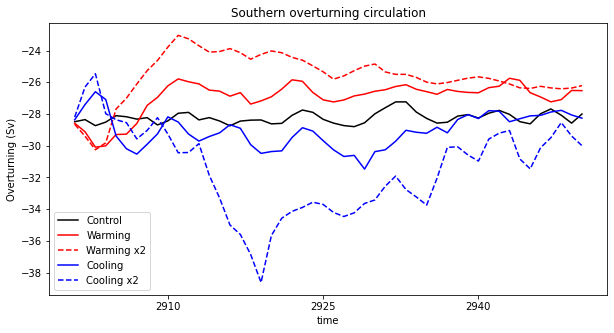

In [21]:
%%time
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2']
colors = {'Windup': 'k','Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b'}
linestyles = {'Windup': '-','Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--'}
start_time = '2900-01-31'
end_time = '2950-01-31'
plt.figure(figsize=(10,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session,ncfile = 'ocean.nc',start_time = start_time, end_time = end_time ).sel(time = slice('2900-01-01','2950-01-01'))
    psi_amoc = (var*indo_sector_mask).sum('grid_xt_ocean')*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session,start_time = start_time, end_time = end_time).sel(time = slice('2900-01-01','2950-01-01'))
        psi_amoc_gm = (var2*indo_sector_mask).sum('grid_xt_ocean')*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum_Sv = psi_amoc_sum.sel(grid_yu_ocean = slice(-90,-20)).sel(potrho=slice(1036.7,1037.5)).min('potrho').min('grid_yu_ocean').resample(time='Y').mean()
    psi_amoc_sum_Sv.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
#     psi_amoc_sum_y = psi_amoc_sum.sel(grid_yu_ocean = slice(40,70)).sel(potrho=slice(1036,1037)).idxmax('grid_yu_ocean').resample(time='Y').mean()
#     psi_amoc_sum_y.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
#     psi_amoc_sum_rho = psi_amoc_sum.sel(grid_yu_ocean = slice(40,70)).sel(potrho=slice(1036,1037)).idxmax('potrho').resample(time='Y').mean()
#     psi_amoc_sum_rho.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
    
xlims = plt.xlim()
#plt.plot(xlims,[17.2,17.2],'--k',label='RAPID (McCarthy et al. 2015)')
plt.legend()
plt.title('Southern overturning circulation')
plt.ylabel('Overturning (Sv)')
plt.savefig('figures/moc')

different resolutions in potrho at 2900. 

1deg_jra55_ryf_red3DSK_C9
1deg_jra55_ryf_RCPcont
1deg_jra55_ryf_RCPwarmhumid
1deg_jra55_ryf_RCPwarmhumid2x
1deg_jra55_ryf_RCPcoolhumid
1deg_jra55_ryf_RCPcoolhumid2x
CPU times: user 1min 48s, sys: 11.1 s, total: 2min
Wall time: 1min 19s


Text(0, 0.5, 'Overturning (Sv)')

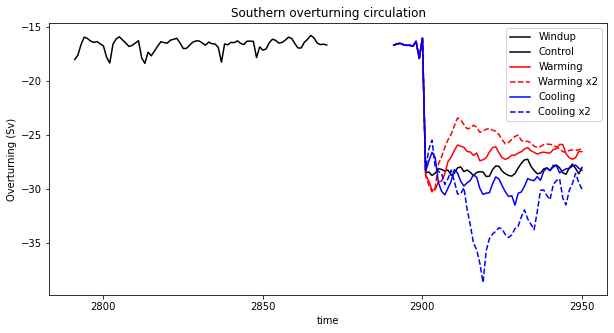

In [23]:
%%time
keys = ['Windup','Control','Warming','Warming x2','Cooling','Cooling x2']
colors = {'Windup': 'k','Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b'}
linestyles = {'Windup': '-','Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--'}
start_time = '2800-01-01'
plt.figure(figsize=(10,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session,start_time = start_time )
    psi_amoc = (var*indo_sector_mask).sum('grid_xt_ocean')*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session,start_time = start_time)
        psi_amoc_gm = (var2*indo_sector_mask).sum('grid_xt_ocean')*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum_Sv = psi_amoc_sum.sel(grid_yu_ocean = slice(-90,-20)).sel(potrho=slice(1036.7,1038)).min('potrho').min('grid_yu_ocean').resample(time='Y').mean()
    psi_amoc_sum_Sv.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
#     psi_amoc_sum_y = psi_amoc_sum.sel(grid_yu_ocean = slice(40,70)).sel(potrho=slice(1036,1037)).idxmax('grid_yu_ocean').resample(time='Y').mean()
#     psi_amoc_sum_y.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
#     psi_amoc_sum_rho = psi_amoc_sum.sel(grid_yu_ocean = slice(40,70)).sel(potrho=slice(1036,1037)).idxmax('potrho').resample(time='Y').mean()
#     psi_amoc_sum_rho.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
    
xlims = plt.xlim()
#plt.plot(xlims,[17.2,17.2],'--k',label='RAPID (McCarthy et al. 2015)')
plt.legend()
plt.title('Southern overturning circulation')
plt.ylabel('Overturning (Sv)')

1deg_jra55_ryf_RCPcont
1deg_jra55_ryf_RCPwarmhumid
1deg_jra55_ryf_RCPwarmhumid2x
1deg_jra55_ryf_RCPcoolhumid
1deg_jra55_ryf_RCPcoolhumid2x
CPU times: user 1min 7s, sys: 6.19 s, total: 1min 13s
Wall time: 51.2 s


Text(0, 0.5, 'Overturning (Sv)')

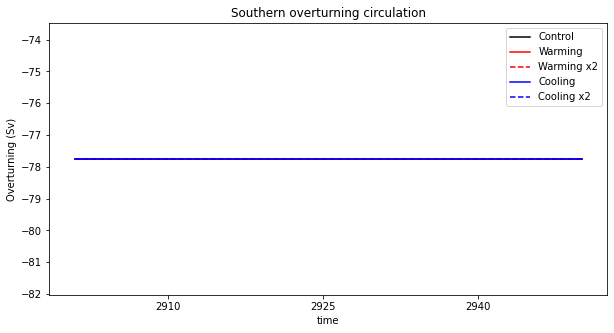

In [22]:
%%time
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2']
colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--'}
start_time = '2900-01-31'
plt.figure(figsize=(10,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session,start_time = start_time )
    psi_amoc = (var*indo_sector_mask).sum('grid_xt_ocean')*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session,start_time = start_time)
        psi_amoc_gm = (var2*indo_sector_mask).sum('grid_xt_ocean')*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
#     psi_amoc_sum_Sv = psi_amoc_sum.sel(grid_yu_ocean = slice(-90,-20)).sel(potrho=slice(1036.7,1038)).min('potrho').min('grid_yu_ocean').resample(time='Y').mean()
#     psi_amoc_sum_Sv.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
    psi_amoc_sum_y = psi_amoc_sum.sel(grid_yu_ocean = slice(-90,-20)).sel(potrho=slice(1036.7,1038)).min('potrho').idxmax('grid_yu_ocean').resample(time='Y').mean()
    psi_amoc_sum_y.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
#     psi_amoc_sum_rho = psi_amoc_sum.sel(grid_yu_ocean = slice(40,70)).sel(potrho=slice(1036,1037)).idxmax('potrho').resample(time='Y').mean()
#     psi_amoc_sum_rho.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
    
xlims = plt.xlim()
#plt.plot(xlims,[17.2,17.2],'--k',label='RAPID (McCarthy et al. 2015)')
plt.legend()
plt.title('Southern overturning circulation')
plt.ylabel('Overturning (Sv)')

1deg_jra55_ryf_RCPcont
1deg_jra55_ryf_RCPwarmhumid
1deg_jra55_ryf_RCPwarmhumid2x
1deg_jra55_ryf_RCPcoolhumid
1deg_jra55_ryf_RCPcoolhumid2x
CPU times: user 1min 7s, sys: 6.9 s, total: 1min 13s
Wall time: 51 s


Text(0, 0.5, 'Overturning (Sv)')

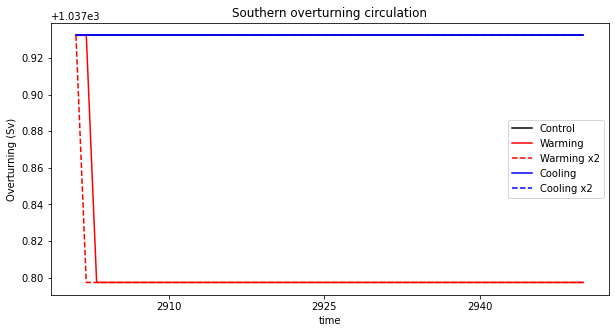

In [23]:
%%time
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2']
colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--'}
start_time = '2900-01-31'
plt.figure(figsize=(10,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session,start_time = start_time )
    psi_amoc = (var*indo_sector_mask).sum('grid_xt_ocean')*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session,start_time = start_time)
        psi_amoc_gm = (var2*indo_sector_mask).sum('grid_xt_ocean')*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
#     psi_amoc_sum_Sv = psi_amoc_sum.sel(grid_yu_ocean = slice(-90,-20)).sel(potrho=slice(1036.7,1038)).min('potrho').min('grid_yu_ocean').resample(time='Y').mean()
#     psi_amoc_sum_Sv.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
#     psi_amoc_sum_y = psi_amoc_sum.sel(grid_yu_ocean = slice(-90,-20)).sel(potrho=slice(1036.7,1038)).min('potrho').idxmax('grid_yu_ocean').resample(time='Y').mean()
#     psi_amoc_sum_y.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
    psi_amoc_sum_rho = psi_amoc_sum.sel(grid_yu_ocean = slice(-90,-20)).sel(potrho=slice(1036.7,1038)).min('grid_yu_ocean').idxmax('potrho').resample(time='Y').mean()
    psi_amoc_sum_rho.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
    
xlims = plt.xlim()
#plt.plot(xlims,[17.2,17.2],'--k',label='RAPID (McCarthy et al. 2015)')
plt.legend()
plt.title('Southern overturning circulation')
plt.ylabel('Overturning (Sv)')

# temp amoc

In [10]:
cc.querying.getvar(expt,'ty_trans_nrho_gm',session,ncfile = 'ocean.nc')

,Array,Chunk
Bytes,3.20 GB,4.00 MB
Shape,"(100, 74, 300, 360)","(1, 37, 150, 180)"
Count,1610 Tasks,800 Chunks
Type,float32,numpy.ndarray


1deg_jra55_ryf_RCPcont
1deg_jra55_ryf_RCPwarmhumid
1deg_jra55_ryf_RCPwarmhumid2x
1deg_jra55_ryf_RCPcoolhumid
1deg_jra55_ryf_RCPcoolhumid2x
CPU times: user 1min 13s, sys: 4.7 s, total: 1min 18s
Wall time: 1min 11s


Text(0, 0.5, 'Overturning (Sv)')

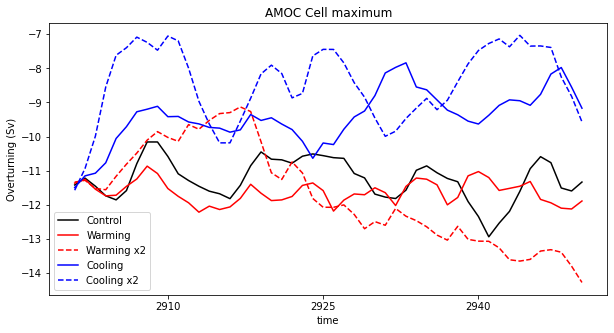

In [12]:
%%time
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2']
colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--'}
start_time = '2900-01-01'
plt.figure(figsize=(10,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_nrho',session,start_time = start_time,ncfile = 'ocean.nc' )
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('neutral') - psi_amoc.sum('neutral')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,start_time = start_time)
        psi_amoc_gm = var2.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean')*1.0e-9
        var3 = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,start_time = start_time)
        psi_amoc_submeso = var3.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean')*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm + psi_amoc_submeso
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(neutral=slice(None,15)).min('neutral').min('grid_yu_ocean').resample(time='Y').mean()
    psi_amoc_sum.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
xlims = plt.xlim()
#plt.plot(xlims,[17.2,17.2],'--k',label='RAPID (McCarthy et al. 2015)')
plt.legend()
plt.title('AMOC Cell maximum')
plt.ylabel('Overturning (Sv)')

In [ ]:
%%time
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2']
colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--'}
start_time = '2900-01-01'
plt.figure(figsize=(10,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_nrho',session,start_time = start_time,ncfile = 'ocean' )
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('neutral') - psi_amoc.sum('neutral')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,start_time = start_time)
        psi_amoc_gm = var2.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean')*1.0e-9
        var3 = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,start_time = start_time)
        psi_amoc_submeso = var3.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean')*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm + psi_amoc_submeso
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(neutral=slice(None,15)).min('neutral').min('grid_yu_ocean').resample(time='Y').mean()
    psi_amoc_sum.plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
xlims = plt.xlim()
#plt.plot(xlims,[17.2,17.2],'--k',label='RAPID (McCarthy et al. 2015)')
plt.legend()
plt.title('AMOC Cell maximum')
plt.ylabel('Overturning (Sv)')

1deg_jra55_ryf_RCPcont
1deg_jra55_ryf_RCPwarmhumid
1deg_jra55_ryf_RCPwarmhumid2x
1deg_jra55_ryf_RCPcoolhumid
1deg_jra55_ryf_RCPcoolhumid2x
1deg_jra55_ryf_RCPcoolhumid_NA
1deg_jra55_ryf_RCPcoolhumid_SO
1deg_jra55_ryf_RCPwarmhumid_NA
1deg_jra55_ryf_RCPwarmhumid_SO
1deg_jra55_ryf_RCPcoolhumid_PI
1deg_jra55_ryf_RCPwarmhumid_PI
CPU times: user 2min 5s, sys: 11.4 s, total: 2min 16s
Wall time: 1min 51s


Text(0, 0.5, 'Overturning (Sv)')

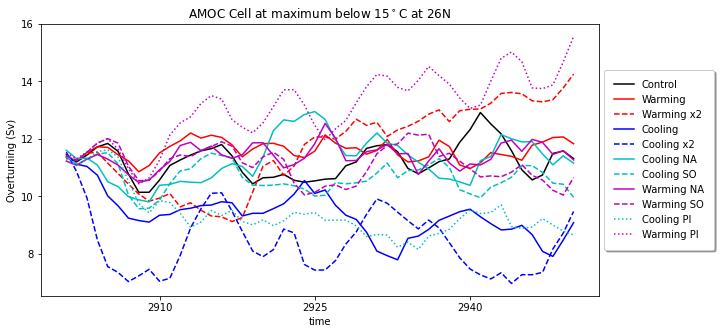

In [13]:
%%time
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2','Cooling NA', 'Cooling SO','Warming NA', 'Warming SO', 'Cooling PI', 'Warming PI']
colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Cooling NA':'c', 'Cooling SO':'c','Warming NA':'m','Warming SO':'m','Cooling PI':'c','Warming PI':'m'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Cooling NA':'-', 'Cooling SO':'--','Warming NA':'-','Warming SO':'--','Warming PI':'dotted','Cooling PI':'dotted'}
start_time = '2900-01-01'
plt.figure(figsize=(10,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_nrho',session,start_time = start_time,end_time = end_time, ncfile = 'ocean.nc' )
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('neutral') - psi_amoc.sum('neutral')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,start_time = start_time,end_time = end_time, ncfile = 'ocean.nc')
        psi_amoc_gm = var2.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
        var3 = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,start_time = start_time)
        psi_amoc_submeso = var3.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm + psi_amoc_submeso
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(neutral=slice(None,15)).min('neutral').resample(time='Y').mean()
    (-1*psi_amoc_sum).plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
xlims = plt.xlim()
#plt.plot(xlims,[17.2,17.2],'--k',label='RAPID (McCarthy et al. 2015)')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(1, 0.5),loc = 'center left')
plt.title('AMOC Cell at maximum below 15$^\circ$C at 26N')
plt.ylabel('Overturning (Sv)')

1deg_jra55_ryf_RCPcoolhumid_NA
1deg_jra55_ryf_RCPwarmhumid_NA
1deg_jra55_ryf_RCPcoolhumid_SO
1deg_jra55_ryf_RCPwarmhumid_SO
1deg_jra55_ryf_RCPcoolhumid_IP
1deg_jra55_ryf_RCPwarmhumid_IP
1deg_jra55_ryf_RCPcoolhumid_SA
1deg_jra55_ryf_RCPwarmhumid_SA
1deg_jra55_ryf_RCPcoolhumid
1deg_jra55_ryf_RCPwarmhumid
1deg_jra55_ryf_RCPcont
CPU times: user 2min 6s, sys: 14.3 s, total: 2min 20s
Wall time: 2min 52s


Text(0, 0.5, 'Overturning (Sv)')

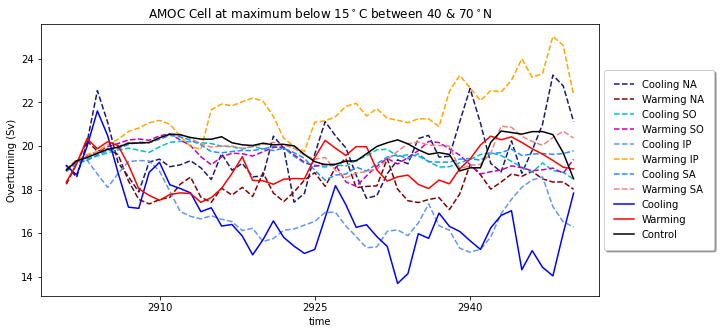

In [12]:
%%time
# keys = ['Control','Warming','Warming x2','Cooling','Cooling x2','Cooling NA', 'Cooling SO','Warming NA', 'Warming SO', 'Cooling PI', 'Warming PI']
# colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Cooling NA':'c', 'Cooling SO':'c','Warming NA':'m','Warming SO':'m','Cooling PI':'c','Warming PI':'m'}
# linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Cooling NA':'-', 'Cooling SO':'--','Warming NA':'-','Warming SO':'--','Warming PI':'dotted','Cooling PI':'dotted'}
# start_time = '2900-01-01'
keys = ['Cooling NA', 'Warming NA', 'Cooling SO','Warming SO','Cooling IP', 'Warming IP', 'Cooling SA', 'Warming SA','Cooling','Warming','Control']
colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Cooling NA':'midnightblue', 'Cooling SO':'c','Warming NA':'maroon','Warming SO':'m','Cooling PI':'c','Warming PI':'m',
         'Cooling IP':'cornflowerblue','Warming IP':'orange','Cooling SA':'dodgerblue','Warming SA':'lightcoral'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Cooling NA':'--', 'Cooling SO':'--','Warming NA':'--','Warming SO':'--','Warming PI':'dotted',
              'Cooling PI':'dotted','Cooling IP':'--','Warming IP':'--','Cooling SA':'--','Warming SA':'--' }
start_time = '2900-01-01'
end_time = '2950-01-01'

plt.figure(figsize=(10,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_nrho',session,start_time = start_time,end_time = end_time, ncfile = 'ocean.nc' )
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean')*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('neutral') - psi_amoc.sum('neutral')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_nrho_gm',session,start_time = start_time,end_time = end_time, ncfile = 'ocean.nc')
        psi_amoc_gm = var2.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean')*1.0e-9
        var3 = cc.querying.getvar(expt,'ty_trans_nrho_submeso',session,start_time = start_time)
        psi_amoc_submeso = var3.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean')*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm + psi_amoc_submeso
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(grid_yu_ocean = slice(40,70)).sel(neutral=slice(None,15)).min('grid_yu_ocean').min('neutral').resample(time='Y').mean()
    (-1*psi_amoc_sum).plot(label=ekey,color=colors[ekey], linestyle = linestyles[ekey])
xlims = plt.xlim()
#plt.plot(xlims,[17.2,17.2],'--k',label='RAPID (McCarthy et al. 2015)')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(1, 0.5),loc = 'center left')
plt.title('AMOC Cell at maximum below 15$^\circ$C between 40 & 70$^\circ$N')
plt.ylabel('Overturning (Sv)')